In [1]:
import torchvision
import torchvision.transforms as transforms
import torch
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch import nn
import time
import random
from PIL import Image
from tempfile import TemporaryDirectory
from torch.optim import lr_scheduler

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Multi-lingual HateSpeech Dataset 

The dataset is hosted on Kaggle in this [repo](https://www.kaggle.com/datasets/wajidhassanmoosa/multilingual-hatespeech-dataset)

#### About Dataset

This dataset contains hate speech text with labels where **0** represents **non-hate** and **1** shows **hate
texts** also the data from different languages needed to be identified as a corresponding
correct language. The following are the languages in the dataset with the numbers corresponding to that language.
(1 Arabic)(2 English)(3 Chinese)(4 French) (5 German) (6 Russian)(7 Turkish) (8 Roman Hindi/Urdu) (9 Korean)(10 Italian) (11 Spanish)(12 Portuguese) (13 Indonesian)

The Dataset also contains LASER 1024-Dimensional embedding for training and test data.

**The goal of our model is to classify whether the text is hate or not.**

### 1. Data analysis

We will use pandas to parse the training dataset and look at a few of its properties and data points.

To maintain repeatability we will use `seed_everything` function recommended [here](https://gist.github.com/ihoromi4/b681a9088f348942b01711f251e5f964)

In [2]:
def seed_everything(seed: int):
  '''
  This function is used to maintain repeatability
  '''
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

In [10]:
train_data = '/kaggle/input/multilingual-hatespeech-dataset/Dataset/Training/MultiLanguageTrainDataset.csv'
df_train = pd.read_csv(train_data, index_col=0)

In [11]:
SEED_VALUE = 42
seed_everything(SEED_VALUE)
# Report the number of sentences.
print(f'Number of training samples: {df_train.shape[0]}.\n')
df_train.sample(5)

Number of training samples: 219981.



,text,label,language
108239,"У нас в России нет чувства налогоплательщика, ...",0.0,6
136061,Çok zekiyim ama kendimi vermiyorum,0.0,7
145789,"olay AKP/MHP çetesinin, muhalefeti parçalama g...",1.0,7
64312,请小姐姐多在知乎发言，那边脑残屌癌言论太多，新近还看到一个夸大“半残”y染色体价值的，估计真有人信,1.0,3
95922,Ich muss kotzen... So etwas gibt es nur in Deu...,1.0,5


Test samples are spread across several files (one for each language), we will concatenate them in a single test dataset `df_test`.

In [12]:
seed_everything(SEED_VALUE)
test_data = '/kaggle/input/multilingual-hatespeech-dataset/Dataset/Testing/Test1/'
df_test = pd.DataFrame(columns=['text', 'label'])

# concatenate all test files into one DataFrame
for file in sorted(os.listdir(test_data)):
    file = pd.read_csv(test_data + file, index_col=0)
    df_test = pd.concat([df_test, file], axis=0) 
df_test.reset_index(drop=True, inplace=True)
print(f'Number of test samples: {df_test.shape[0]}.\n')
df_test.sample(5)

Number of test samples: 24449.



,text,label
7937,Beaucoup enlevÃ© leur voile pour bosser.,0.0
16888,"Жил в общаге и заполнил заявку, пока они ее од...",0.0
12981,"Pontina, controlli serrati al campo rom di via...",0.0
11257,"Sehr gute Idee, die Legos zu verschönern(Frau ...",0.0
24168,İnsanın gözü aşina olup kimdi kimdi die düşünm...,0.0


In [13]:
seed_everything(SEED_VALUE)
print('Examples of non-hate texts in Russian:\n')
print(*enumerate(df_train[(df_train['language'] == 6) & (df_train['label'] == 0)].sample(5)['text'].values), sep = '\n')

Examples of non-hate texts in Russian:

(0, 'Как работает тонометр в фитнес-часах? Добро пожаловать в 21 век!')
(1, 'Мне кажется, что ритуал экзорцизма обойдется дешевле Алабая')
(2, 'У моего отца стаж с 1971 года (47 лет). И он и сейчас еще работает водителем. Может этой весной уговорим уйти на пенсию.')
(3, 'Тотальная дискредитация косплееров это, а не комикс. Что сама идея, что выбор костюма.')
(4, 'вот вроде не при делах, но за город стыдно')


In [14]:
seed_everything(SEED_VALUE)
print('Examples of hate texts in Russian:\n')
print(*enumerate(df_train[(df_train['language'] == 6) & (df_train['label'] == 1)].sample(5)['text'].values), sep = '\n')

Examples of hate texts in Russian:

(0, 'Думаешь термин хохол,москаль во времена интернета придумали.....')
(1, 'Ни одной годной сельди: сплошные визгливые шлюхи с мазиком и бабушка открыла секрет .')
(2, 'Типичные зумеры-сойбои. Типичные баззворды альтрайта))000')
(3, 'Дает, но уродится косоглазо пиздоглазый даун, т.е. руццкий')
(4, 'Зачем Алекс Пыня залупается на людей умнее его? Ему нравится полным дебилом на их фоне выглядеть? Был же тот же Золотов, во время срача с которым даже не понятно кто мразотнее поначалу.')


In [15]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 219981 entries, 0 to 219980
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   text      219981 non-null  object 
 1   label     219981 non-null  float64
 2   language  219981 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 6.7+ MB


Let us check that there are not any NaNs in the dataset (just in case).

In [9]:
print('Do features have no NaNs?')
print(f'\nTraining dataset:')
display(df_train.notna().all())

print(f'\nTest dataset:')
display(df_test.notna().all())

Do features have no NaNs?

Training dataset:


text        True
label       True
language    True
dtype: bool


Test dataset:


text     True
label    True
dtype: bool

Let us evaluate class distribution for the `label` feature,
where 0 - non-hate texts, 1 - hate texts.

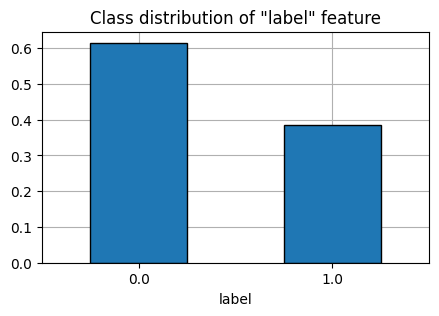

In [11]:
import matplotlib.pyplot as plt

def plot_distrib(feature):
    plt.figure(figsize=(5, 3))
    (feature.value_counts(normalize=True)
                      .plot(kind='bar', edgecolor='black', zorder=2));
    plt.xticks(rotation=0)
    plt.grid(zorder=0)
    plt.title(f'Class distribution of "{feature.name}" feature');
plot_distrib(df_train['label'])

As we can see classes slightly imbalanced, we will take this observation into account choosing a quality metric.

In [12]:
len_in_chars = df_train['text'].apply(len)
print(f'An average sentence consists of {round(len_in_chars.mean())} characters')

An average sentence consists of 129 characters


Let us calculate mean sentence length in words:

In [13]:
# import string library function  
import string  

def remove_punctuation(text: str):
    '''
    This function is used to remove punctuation from lowercased sentences
    '''
    text = text.lower()
    text = [letter for letter in text if letter not in string.punctuation]
    if text:
        return text
    return [text]   

In [14]:
len_in_words = df_train['text'].apply(lambda x: (len(remove_punctuation(x))))

# # Print length of an average sentence
print(f'An average   text consists of {round(len_in_words.mean())} words')

# Print length of the shortest sentence
print(f'The shortest text consists of {round(len_in_words.min())} words')

# Print length of the longest sentence
print(f'The longest  text consists of {round(len_in_words.max())} words')

An average   text consists of 123 words
The shortest text consists of 1 words
The longest  text consists of 19167 words


# 2. Baseline
###  2.1. Usage of BERT to get embeddings from the train dataset and data vectorization

Download tokenizer and the model from Hugging Face.

In [13]:
from transformers import AutoTokenizer, BertModel

In [14]:
# Load pre-trained model tokenizer (vocabulary)
print('Loading BERT tokenizer...')
base_model = "bert-base-multilingual-uncased"
tokenizer = AutoTokenizer.from_pretrained(base_model)
print('Completed!')

Loading BERT tokenizer...
Completed!


In [63]:
def get_sentence_embedding(text, bert_model):
    '''
    Input:
    text: str - string of raw text
    Output:
    sentence_embedding: np.array - numpy array of shape (1, 768)
                        represents a whole string of raw text
    '''
    
    input_ids, token_type_ids, attention_mask\
                = tokenizer(text, add_special_tokens = True,
                            truncation = True, padding = True,
                            return_attention_mask = True,    
                            return_tensors = "pt").values()
    with torch.no_grad():      
        input_ids = input_ids.to(device)
        token_type_ids = token_type_ids.to(device)
        attention_mask = attention_mask.to(device)
        sentence_embedding = bert_model(input_ids,
                                    attention_mask=attention_mask,
                                    token_type_ids=token_type_ids)

    return sentence_embedding.last_hidden_state[:, 0, :].cpu()
                                                        .numpy().squeeze()

In [16]:
X_train_text = df_train['text'].values
y_train = df_train['label'].map(int).values
X_test_text = df_test['text'].values
y_test = df_test['label'].map(int).values
print('Examples of train samples:')
display(X_train_text[40000:40003], y_train[40000:40003])
display(X_train_text.shape, X_test_text.shape)

Examples of train samples:


array(['@twitter @jack ONCE AGAIN we see how CORPORATIONS cause HATE, DIVISION and SUFFERING. Did you know JACK is on #ISIS hit list? Not telling J',
       '@user dont enough gook ching chong badly',
       'When they see #IS gaining we always hear stuff like: "ISIL is clearly trying to project strength". As if to calm down their readers. '],
      dtype=object)

array([0, 0, 1])

(219981,)

(24449,)

In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device.


In [19]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 2 GPU(s) available.
We will use the GPU: Tesla T4


In [66]:
bert_model = BertModel.from_pretrained(base_model,
                                       output_hidden_states=True)
# Put the model in "evaluation" mode, meaning feed-forward operation.
bert_model = bert_model.eval()
bert_model = bert_model.to(device)

Let us get sentence embeddings for X_train and X_test, using BERT and helper function implemented above.

In [67]:
X_train_path = '/kaggle/working/X_train.npy'
if not os.path.exists(X_train_path):
    X_train = []
    for sample in tqdm(X_train_text):
        embedding = get_sentence_embedding(sample, bert_model)
        X_train.append(embedding)
    X_train = np.array(X_train)
    print('Examples of train samples:')
    display(X_train[40000:40001], y_train[40000:40001])
    display(X_train.shape)

100%|██████████| 219981/219981 [47:16<00:00, 77.55it/s] 


Examples of train samples:


array([[-1.32571578e-01, -5.39221466e-02,  4.12117504e-02,
        -6.21537343e-02, -2.82101542e-01,  7.20179379e-02,
         9.19195414e-02,  3.70926112e-02, -1.83422494e+00,
        -7.65472800e-02, -1.81897730e-01, -6.68610036e-02,
        -4.62960303e-02,  1.76259249e-01,  2.22217008e-01,
         1.28006518e-01, -3.46882222e-03, -3.72550040e-02,
        -1.33443414e-03,  1.43960476e-01,  5.51501550e-02,
         8.81689861e-02, -1.16819136e-01, -3.66098434e-03,
         5.92971623e-01, -1.05108865e-01, -3.20056640e-02,
         3.44415987e-03, -2.03993678e+00,  5.22508696e-02,
        -2.82742441e-01,  1.12397358e-01, -5.72733674e-03,
        -3.89947630e-02, -5.70439510e-02, -1.48010105e-01,
         1.22101262e-01,  1.59992445e+00, -8.47419202e-02,
        -1.90196023e-03, -7.22740442e-02, -6.42957464e-02,
        -1.35879844e-01,  1.13927178e-01, -7.55814314e-02,
        -2.97889137e-03,  7.74501339e-02,  6.22660331e-02,
        -1.68810204e-01,  1.01719774e-01, -4.84394319e-0

array([0])

(219981, 768)

In [74]:
X_test_path = '/kaggle/working/X_test.npy'
if not os.path.exists(X_test_path):    
    X_test = []
    for sample in tqdm(X_test_text):
        embedding = get_sentence_embedding(sample, bert_model)
        X_test.append(embedding)
    X_test = np.array(X_test)    
    display(X_test.shape)    

100%|██████████| 24449/24449 [05:19<00:00, 76.47it/s]


(24449, 768)

Since calculations of the sentence embeddings took a while, let us save `X_train` and `X_test` at `/kaggle/working/` directory for futher usage.

In [71]:
def save_result(data, file):
    '''
    Function to save data at local disk
    '''
    with open(file, 'wb') as f: # save data 
        np.save(f, data)
    with open(file, 'rb') as f:
        data_copy = np.load(f)    # read data
    if (data_copy == data).all(): # if initial data == saved data 
        print(f'File {file.split("/")[-1]} saved at local disk')

In [73]:
if not os.path.exists(X_train_path):
    save_result(X_train, X_train_path)

In [76]:
if not os.path.exists(X_test_path):
    save_result(X_test, X_test_path)

File X_test.npy saved at local disk


If X_train and X_test have been already calculated:

In [17]:
X_train_path = '/kaggle/input/bert-embeddings/X_train.npy'
if os.path.exists(X_train_path):
    with open(X_train_path, 'rb') as f:
        X_train = np.load(f)
display(X_train.shape)

(219981, 768)

In [18]:
X_test_path = '/kaggle/input/bert-embeddings/X_test.npy'
if os.path.exists(X_test_path):
    with open(X_test_path, 'rb') as f:
        X_test = np.load(f)
display(X_test.shape)

(24449, 768)

### 2.3 Train CatBoostClassifier, using BERT embeddings as features to a classifier.

In [28]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
# Initialize CatBoostClassifier
classifier = CatBoostClassifier(iterations=100,
                                task_type="GPU",
                                devices="0:1", 
                                verbose=False)
# Fit model
classifier.fit(X_train, y_train)

Get predictions on the test data and calculate accuracy.

In [29]:
# Get predicted classes
preds_class = classifier.predict(X_test)
accuracy = accuracy_score(y_test, preds_class)
accuracy

0.746247290277721

In [31]:
results = dict()
results['baseline'] = round(accuracy, 2)
results

{'baseline': 0.75}

# 3. Fine-tune BERT

In this section, we will transform our dataset into the format that BERT can be trained on.

## 3.1. BERT Tokenizer

To feed our text to BERT, it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary.

The tokenization must be performed by the tokenizer included with BERT - the below cell will download this for us. We will be using the "multilingual-uncased" version here (the same version was used for the baseline in paragraph 2.1).


In [32]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
base_model = "bert-base-multilingual-uncased"
tokenizer = AutoTokenizer.from_pretrained(base_model);
print('Completed!')

Loading BERT tokenizer...
Completed!


When we actually convert all of our sentences, we'll use the `tokenize.encode` function to handle both steps, rather than calling `tokenize` and `convert_tokens_to_ids` separately.

Before we can do that, though, we need to talk about some of BERT's formatting requirements.

### 3.2. Required Formatting

We are required to:
1. Add special tokens to the start and end of each sentence.
2. Pad & truncate all sentences to a single constant length.
3. Explicitly differentiate real tokens from padding tokens with the "attention mask".

### 3.3. Training & Validation Split, Tokenization

In [55]:
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader
from datasets import Dataset

from tqdm.auto import tqdm, trange

from torch.optim import Adam

from sklearn.model_selection import train_test_split

In [78]:
df_train['label'] = df_train['label'].map(int)
df_test['label'] = df_test['label'].map(int)

In [14]:
from torch.utils.data import TensorDataset, random_split

data = Dataset.from_dict({'text': df_train['text'],
                          'label': df_train['label']}).train_test_split(test_size=0.1,
                                                                        seed=SEED_VALUE)

data_test = Dataset.from_dict({'text': df_test['text'],
                          'label': df_test['label']})
data

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 197982
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 21999
    })
})

Let us check distribution of `label` classes in train and test datasets

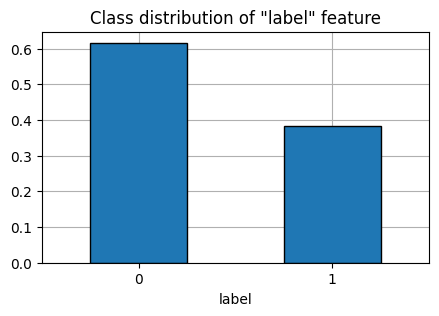

In [24]:
plot_distrib(pd.Series(data['train']['label'], name='label'))

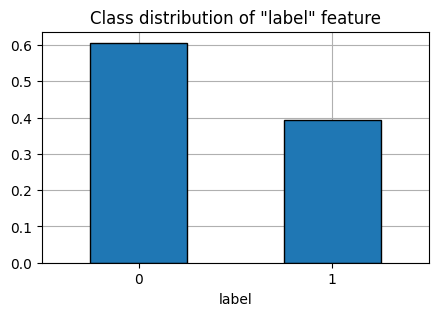

In [25]:
plot_distrib(pd.Series(data['test']['label'], name='label'))

Tokenization and formatting of the data.

In [15]:
data_tokenized = data.map(lambda x: tokenizer(x['text'],
                          truncation=True, max_length=512),
                          batched=True, remove_columns=['text'])
data_test_tokenized = data_test.map(lambda x: tokenizer(x['text'],
                          truncation=True, max_length=512),
                          batched=True, remove_columns=['text'])

  0%|          | 0/198 [00:00<?, ?ba/s]

  0%|          | 0/22 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

In [81]:
data_tokenized, data_test_tokenized

(DatasetDict({
     train: Dataset({
         features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
         num_rows: 197982
     })
     test: Dataset({
         features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
         num_rows: 21999
     })
 }),
 Dataset({
     features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 24449
 }))

In [33]:
print(data_tokenized['train'][0])

{'label': 0, 'input_ids': [101, 21637, 10747, 70044, 37180, 10744, 28232, 56246, 36851, 47346, 11169, 10150, 100, 100, 100, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [16]:
collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [17]:
train_dataloader = DataLoader(data_tokenized['train'], shuffle=True,
                              batch_size=16, collate_fn=collator)
val_dataloader = DataLoader(data_tokenized['test'], shuffle=False,
                            batch_size=16, collate_fn=collator)
test_dataloader = DataLoader(data_test_tokenized, shuffle=False,
                            batch_size=16, collate_fn=collator)

### 3.4. Initialize the model, optimizer and learning rate scheduler

We'll be using [BertForSequenceClassification](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#bertforsequenceclassification). This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task.


In [54]:
from transformers import AutoModelForMaskedLM, AdamW, BertConfig, BertForSequenceClassification

# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
# model = AutoModelForMaskedLM.from_pretrained(
model = BertForSequenceClassification.from_pretrained(
    base_model, # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.                    
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.to(device)

Just for curiosity's sake, we can browse all of the model's parameters by name here.

In the below cell, I've printed out the names and dimensions of the weights for:

1. The embedding layer.
2. The first of the twelve transformers.
3. The output layer.

In [38]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (105879, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              

In [39]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [40]:
import gc
gc.collect()
torch.cuda.empty_cache()

### 3.5. Training loop and fine-tune BERT

In [42]:
EPOCHS = 2
losses = []
for epoch in trange(EPOCHS, desc=f"Traning Model on {EPOCHS} Epochs"):
    pbar = tqdm(train_dataloader)
    model.train()
    for i, batch in enumerate(pbar):
        out = model(**batch.to(model.device))
        out.loss.backward()
        if i % 1 == 0:
            optimizer.step()
            optimizer.zero_grad()
        losses.append(out.loss.item())
        pbar.set_description(f'Epoch {epoch + 1}/{EPOCHS}, loss: {np.mean(losses[-100:]):2.2f}')
    model.eval()
    eval_losses = []
    eval_preds = []
    eval_targets = []
    for batch in tqdm(val_dataloader, desc=f'Validation phase  {epoch + 1}/{EPOCHS}'):
        with torch.no_grad():
                out = model(**batch.to(model.device))
        eval_losses.append(out.loss.item())
        eval_preds.extend(out.logits.argmax(1).tolist())
        eval_targets.extend(batch['labels'].tolist())
    print(f'recent train loss: {np.mean(losses[-100:]):2.2f},',
          f'eval loss: {np.mean(eval_losses):2.2f},',
          f'accuracy: {np.mean(np.array(eval_targets) == eval_preds):2.2f}')

Traning Model on 2 Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/12374 [00:00<?, ?it/s]

Validation phase  1/2:   0%|          | 0/1375 [00:00<?, ?it/s]

recent train loss: 0.38, eval loss: 0.35, accuracy: 0.84


  0%|          | 0/12374 [00:00<?, ?it/s]

Validation phase  2/2:   0%|          | 0/1375 [00:00<?, ?it/s]

recent train loss: 0.28, eval loss: 0.35, accuracy: 0.86


Evaluation on Validation dataset

In [43]:
model.eval()
eval_losses = []
eval_preds = []
eval_targets = []
for batch in tqdm(val_dataloader):
    with torch.no_grad():
            out = model(**batch.to(model.device))
    eval_losses.append(out.loss.item())
    eval_preds.extend(out.logits.argmax(1).tolist())
    eval_targets.extend(batch['labels'].tolist())
print(f'eval loss: {np.mean(eval_losses):2.2f},',
      f'accuracy: {np.mean(np.array(eval_targets) == eval_preds):2.2f}.')

  0%|          | 0/1375 [00:00<?, ?it/s]

eval loss: 0.35, accuracy: 0.86.


Evaluation on a test dataset

In [83]:
model.eval()
eval_losses = []
eval_preds = []
eval_targets = []
for batch in tqdm(test_dataloader):
    with torch.no_grad():
            out = model(**batch.to(model.device))
    eval_losses.append(out.loss.item())
    eval_preds.extend(out.logits.argmax(1).tolist())
    eval_targets.extend(batch['labels'].tolist())
print(f'eval loss: {np.mean(eval_losses):2.2f},',
      f'accuracy: {np.mean(np.array(eval_targets) == eval_preds):2.2f}.')

  0%|          | 0/1529 [00:00<?, ?it/s]

eval loss: 0.34, accuracy: 0.86.


In [32]:
accuracy = 0.86
results['fine_tuned_BERT'] = round(accuracy, 2)
results

{'baseline': 0.75, 'fine_tuned_BERT': 0.86}

In [45]:
model_path = '/kaggle/working/model_2epochs'
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('/kaggle/working/model_2epochs/tokenizer_config.json',
 '/kaggle/working/model_2epochs/special_tokens_map.json',
 '/kaggle/working/model_2epochs/vocab.txt',
 '/kaggle/working/model_2epochs/added_tokens.json',
 '/kaggle/working/model_2epochs/tokenizer.json')

Inference on a random text

In [157]:
test_sentences = ["Дорогие россияне! С новым годом!",
                  "I'd like to congratulate you on Halloween, wish you bad luck, bustard",
                  "A freshman year was a disaster!",
                  "WOW, it's an apple watch, great present ever!",
                  "Подходи, буржуй, глазик выколю",
                  "Ich kann nicht conzentriren!"]
test_sentences_tokenized = [tokenizer(test_sentence, truncation=True,
                 max_length=512, return_tensors='pt') for test_sentence in test_sentences]

In [158]:
model.eval()
for sentence in test_sentences_tokenized:
    with torch.no_grad():
        out = model(**sentence.to(model.device))
        result = out.logits.argmax().item()
        if result:
            print("Your text has curse words and won't be published!")
        else:
            print('You are good!')

You are good!
Your text has curse words and won't be published!
You are good!
You are good!
Your text has curse words and won't be published!
You are good!


Results of predictions on random texts are quite good: all hate texts were successfully identified.

# Conclusion

In [62]:
for key, value in results.items():
    print(f'For {key:<15} accuracy is {value}.')

For baseline        accuracy is 0.75.
For fine_tuned_BERT accuracy is 0.86.


In our project, we compared the accuracy of two approaches:
 - baseline: CatBoosClassifier, using Bert embeddings, gave us an accuracy of 0.75;
 - a pre-trained BERT fine-tuned for our downstream task achieved an accuracy of 0.86 (due to lack of computing resources, the training process took only two epochs).
 
Thus, we received an 11% increase in accuracy.
We can conclude that a fine-tuned neural network based on the Transformers architecture can achieve significantly better results on an NLP task.